In [1]:
# Импорт всех необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
pd.set_option("plotting.backend", "matplotlib")

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')

In [2]:
PATH_base = './data'

df_train = pd.read_csv(PATH_base + '/train.csv', delimiter=',')
df_test = pd.read_csv(PATH_base + '/test.csv', delimiter=',')
df_submit = pd.read_csv(PATH_base + '/sample_submission.csv', delimiter=',')

In [3]:
train_dup_rows = df_train.duplicated()
train_dup_rows.sum()

0

In [4]:
df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])

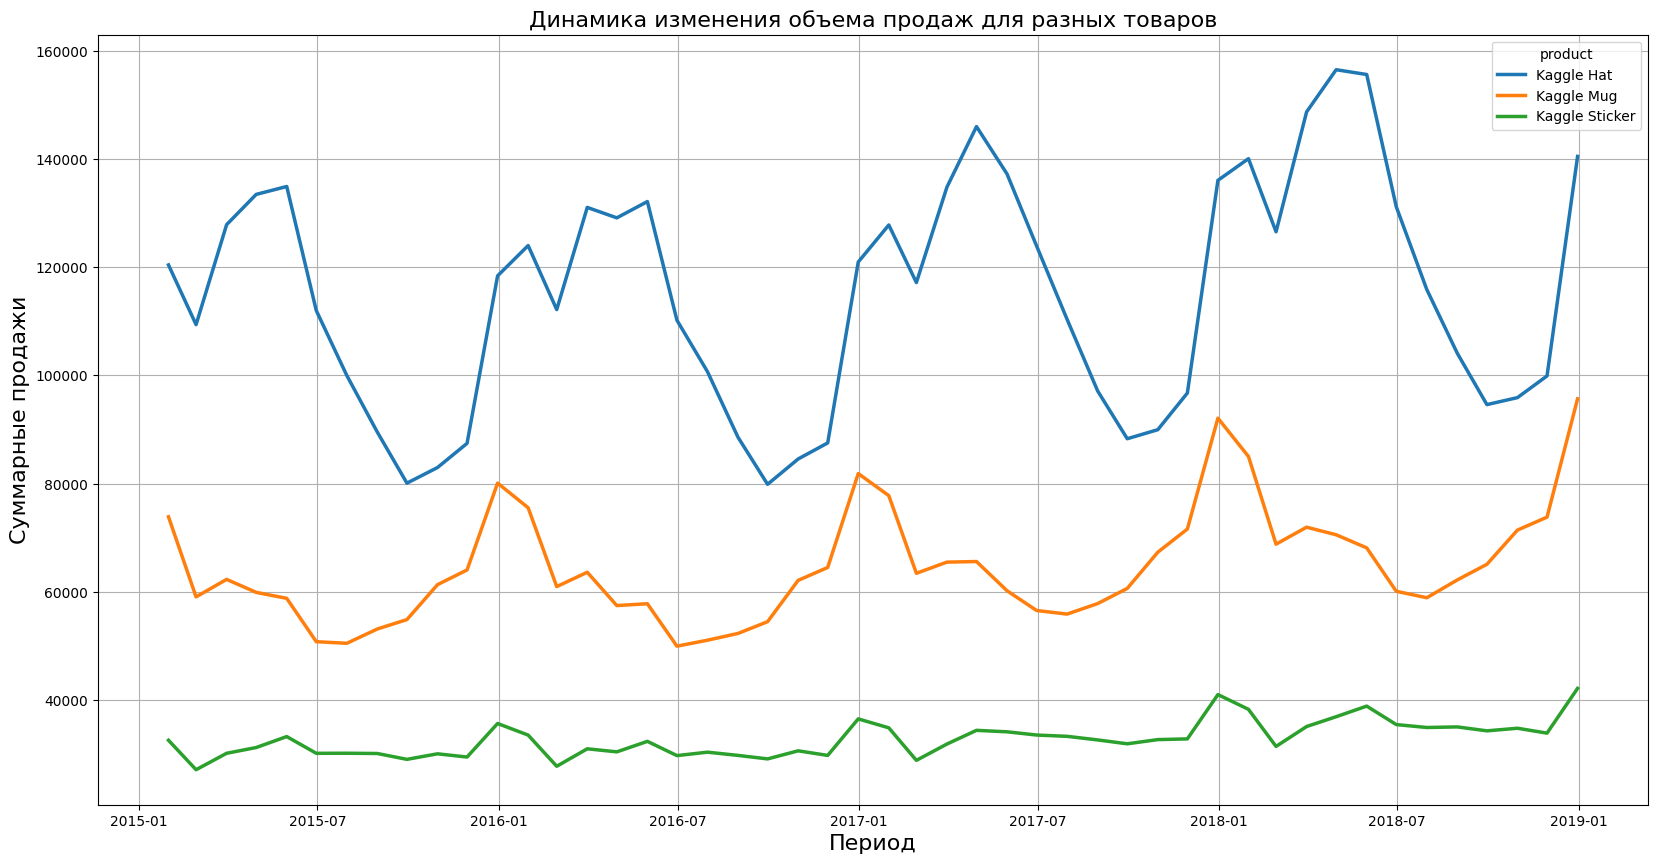

In [5]:
df1=df_train.groupby([pd.Grouper(key="date", freq="1M"), 'product'])[["num_sold"]].sum()
fig1 = plt.figure(figsize=(20, 10))
barplot=sns.lineplot(data=df1,x='date', y='num_sold', hue='product', palette="tab10", linewidth=2.5)
barplot.set_title('Динамика изменения объема продаж для разных товаров', fontsize=16)
barplot.set_xlabel('Период', fontsize=16);
barplot.set_ylabel('Суммарные продажи', fontsize=16);
barplot.grid()

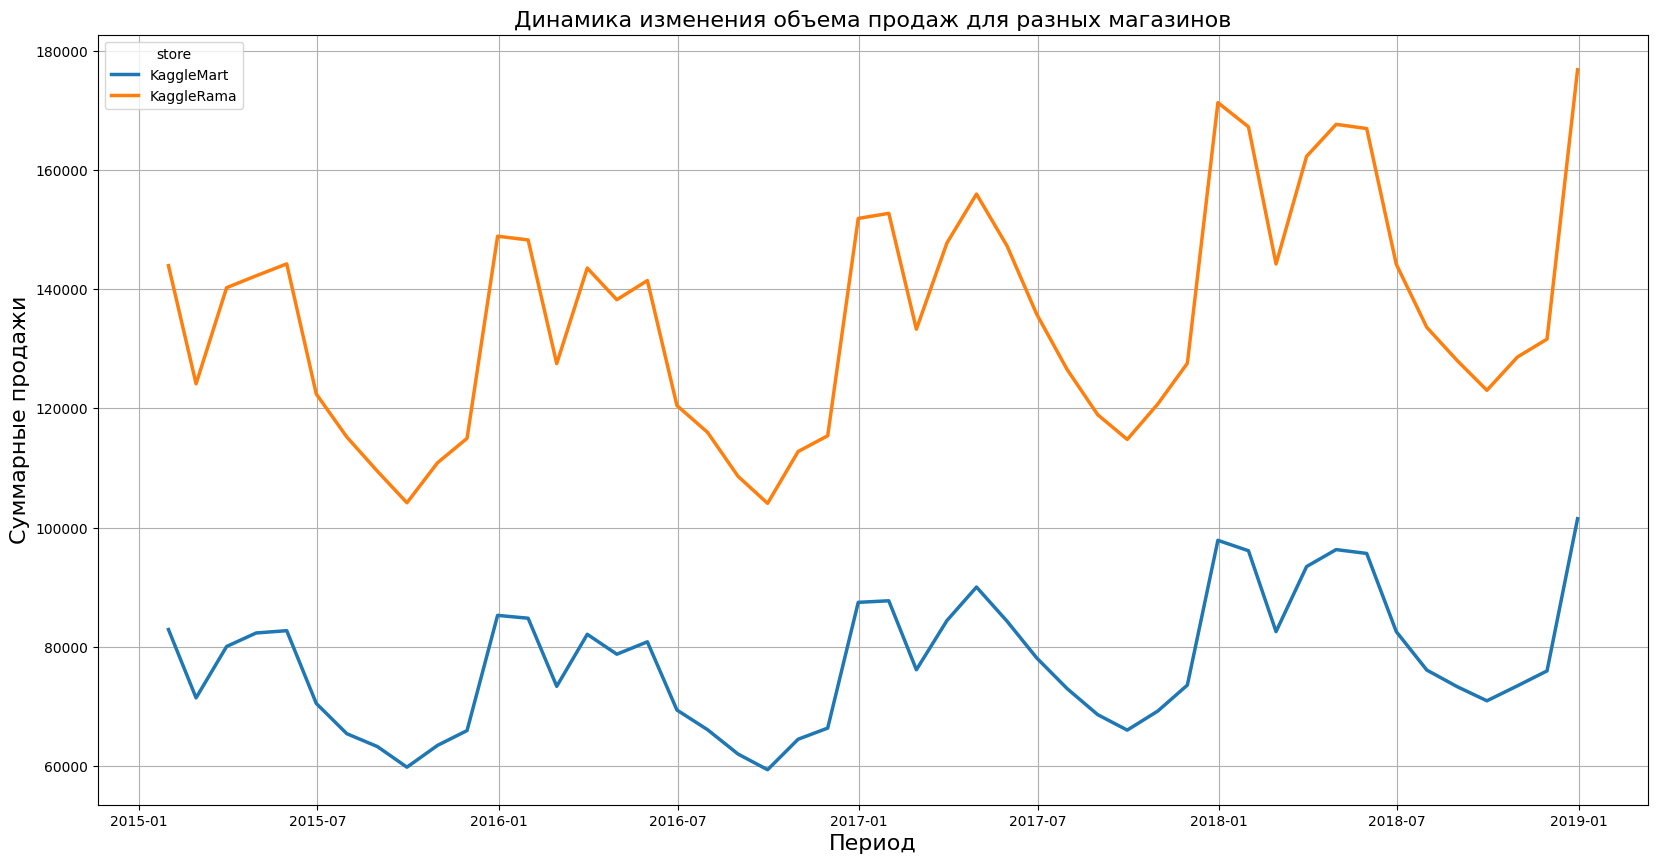

In [6]:
df1=df_train.groupby([pd.Grouper(key="date", freq="1M"), 'store'])[["num_sold"]].sum()
fig2 = plt.figure(figsize=(20, 10))
barplot=sns.lineplot(data=df1,x='date', y='num_sold', hue='store', palette="tab10", linewidth=2.5)
barplot.set_title('Динамика изменения объема продаж для разных магазинов', fontsize=16)
barplot.set_xlabel('Период', fontsize=16);
barplot.set_ylabel('Суммарные продажи', fontsize=16);
barplot.grid()

In [7]:
def process_data(df_source, scaler, to_fit_scaler=False):
    df_source["date"] = pd.to_datetime(df_source["date"])
    df_one_hot_encoded = pd.get_dummies(df_source[['country', 'store', 'product']],
                                        prefix=['country', 'store', 'product'], dtype=int)
    df_new = pd.concat([df_source, df_one_hot_encoded], axis=1)
    df_new['year'] = df_new['date'].dt.year
    df_new['month'] = df_new['date'].dt.month
    df_new["day"] = df_new["date"].dt.dayofyear
    df_new["dayofweek"] = df_new["date"].dt.weekday

    columns_to_drop = ["date", "country", "store", "product"]
    df_new = df_new.drop(columns=columns_to_drop)

    col_modify_scaling = ["dayofweek", "day", "month"]

    if to_fit_scaler:
        scaler.fit(df_new[col_modify_scaling])

    df_new[col_modify_scaling] = scaler.transform(df_new[col_modify_scaling])
    df_new['year'] = df_new['year'].rank(method='dense').astype(int)

    return df_new

In [8]:
min_max_scaler = MinMaxScaler()
train_df_pr = process_data(df_train, min_max_scaler, True)
test_df_pr = process_data(df_test, min_max_scaler, False)

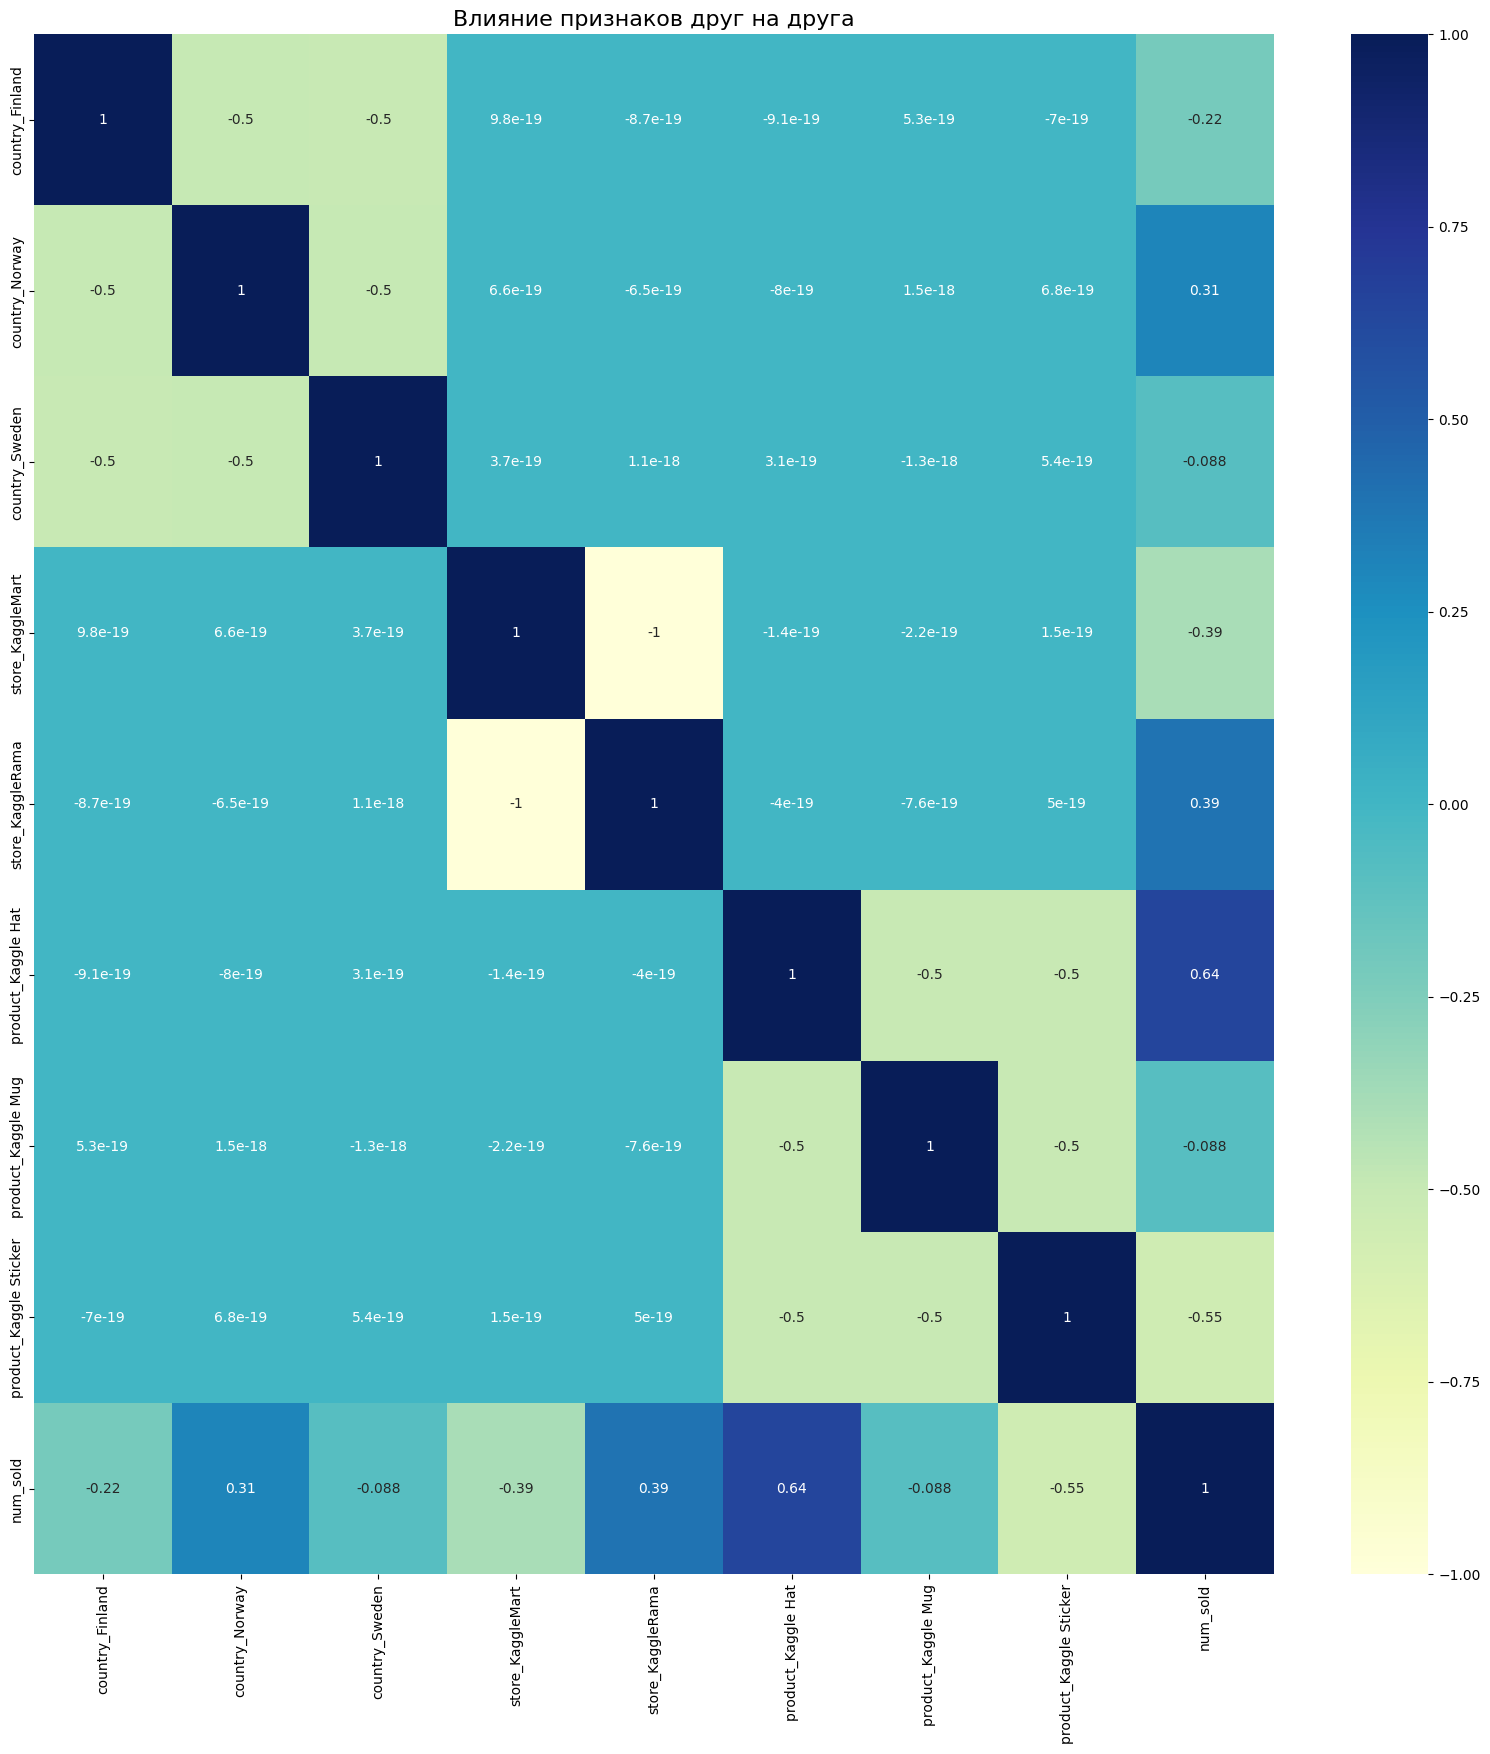

In [9]:
plt.figure(figsize=(20, 20))
data_features=["country_Finland", "country_Norway","country_Sweden","store_KaggleMart","store_KaggleRama", "product_Kaggle Hat", "product_Kaggle Mug","product_Kaggle Sticker", 'num_sold' ]
plot_data = sns.heatmap(train_df_pr[data_features].corr(), cmap="YlGnBu", annot=True);
plot_data.set_title('Влияние признаков друг на друга', fontsize=16);

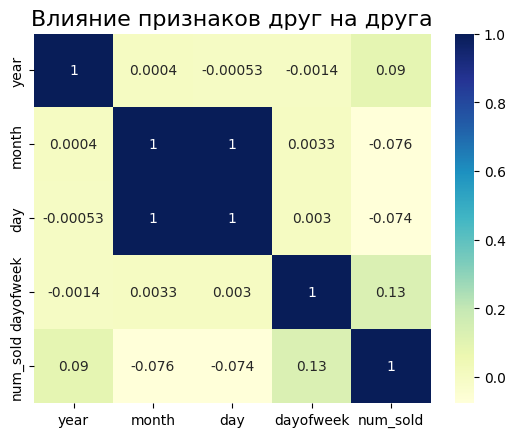

In [10]:
data_features=['year','month',"day","dayofweek", 'num_sold' ]
plot_data = sns.heatmap(train_df_pr[data_features].corr(), cmap="YlGnBu", annot=True);
plot_data.set_title('Влияние признаков друг на друга', fontsize=16);

In [9]:
train_df_x = train_df_pr[["country_Finland", "country_Norway", "country_Sweden", "store_KaggleMart", "store_KaggleRama",
                          "product_Kaggle Hat", "product_Kaggle Mug", "product_Kaggle Sticker", "year", "month",
                          "dayofweek", "day"]]
train_df_y = train_df_pr[["num_sold"]]
X_train, X_valid, y_train, y_valid = train_test_split(train_df_x, train_df_y, test_size=0.3, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(18408, 12) (7890, 12) (18408, 1) (7890, 1)


In [10]:
X_test = test_df_pr[["country_Finland", "country_Norway", "country_Sweden", "store_KaggleMart", "store_KaggleRama",
                  "product_Kaggle Hat", "product_Kaggle Mug", "product_Kaggle Sticker", "year", "month",
                  "dayofweek", "day"]]

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import numpy as np

model = LinearRegression()

model.fit(X_train, y_train)

y_valid_pred_mlr = model.predict(X_valid)

smape_mlr = smape(y_valid, y_valid_pred_mlr)

print("SMAPE multi-linear regression : ", smape_mlr)

SMAPE multi-linear regression :  31.042696875848033


In [14]:
from sklearn.preprocessing import PolynomialFeatures

degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.transform(X_valid)
X_test_poly = poly.transform(X_test)

model_p = LinearRegression()

model_p.fit(X_train_poly, y_train)

y_valid_pred_p = model_p.predict(X_valid_poly)

smape_p = smape(y_valid, y_valid_pred_p)

print("SMAPE polynomial regression : ", smape_p)

y_test_pred_p = model_p.predict(X_test_poly)



SMAPE polynomial regression :  14.334075191442937


In [15]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

model_rf.fit(X_train, y_train)

y_valid_pred_rf = model_rf.predict(X_valid)

smape_rf = smape(y_valid, y_valid_pred_rf)

print("SMAPE random forest regression : ", smape_rf)

y_test_pred_rf = model_rf.predict(X_test)

/var/lib/python/python_venvs/torch_streamlit/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


SMAPE random forest regression :  5.661913803672122


In [16]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

model_xgb.fit(X_train, y_train)

y_valid_pred_xgb = model_xgb.predict(X_valid)

smape_xgb = smape(y_valid, y_valid_pred_xgb)

print("SMAPE XGBoost regression : ", smape_xgb)

y_test_pred_xgb = model_xgb.predict(X_test)



SMAPE XGBoost regression :  4.859086390128584


In [18]:
from xgboost import XGBRegressor
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.transform(X_valid)
X_test_poly = poly.transform(X_test)

model_xgb2 = XGBRegressor(objective='reg:squarederror', random_state=42)

model_xgb2.fit(X_train_poly, y_train)

y_valid_pred_xgb2 = model_xgb2.predict(X_valid_poly)

smape_xgb2 = smape(y_valid, y_valid_pred_xgb2)

print("SMAPE XGBoost regression : ", smape_xgb2)

y_test_pred_xgb2 = model_xgb2.predict(X_test_poly)

SMAPE XGBoost regression :  4.789301344788993


In [29]:
result_df2 = pd.DataFrame(list(zip(df_test.row_id, y_test_pred_xgb2)),columns = ['row_id', 'num_sold'])
result_df2.to_csv(PATH_base + "/submission.csv", index=False)

In [12]:
y_test_pred = model.predict(X_test)

In [42]:
df2= pd.concat([df_test['row_id'],   pd.DataFrame( y_test_pred, columns=['num_sold'])], axis=1)
df2.num_sold=df2.num_sold.astype('int')
df2

,row_id,num_sold
0,26298,130
1,26299,405
2,26300,-36
3,26301,336
4,26302,611
...,...,...
6565,32863,395
6566,32864,-46
6567,32865,326
6568,32866,601
